# Zadanie

Wybierz zbiór danych i zdefiniuj problem regresyjny, określając zmienną docelową oraz cechy
objaśniające. 

1. Przeprowadź przygotowanie danych, obejmujące:
    - Usunięcie duplikatów, obsługę braków danych.
    - Kodowanie zmiennych kategorycznych oraz detekcję wartości odstających.
    - Skalowanie zmiennych numerycznych (jeśli konieczne).

2. Podziel dane na zbiór treningowy i testowy oraz zastosuj odpowiednie metody inżynierii cech.

3. Zbuduj model regresji liniowej jako benchmark, a następnie przeprowadź predykcję i ocenę jakości
modelu przy użyciu metryk: MAE, MSE, RMSE, R².

Wybrane dane dostępne w `./data` pochodzą z poe.ninja i są bezpośrednim odwzorowaniem ruchu ekonomicznego danej ligi (okresowego etapu rozgrywki) z gry komputerowej Path of Exile.

Potencjalne problemy regresyjne:
+ przewidywanie przyszłej ceny waluty / przedmiotu
+ przewidywanie wpływu popytu / podaży na cene
+ przewidywanie zmienności ceny walut / przedmiotów

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Załóżmy, że plik load_data.py znajduje się w tym samym katalogu
import load_data as dataLoader

# Ustawienia wizualizacji
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Wczytanie danych
df_currency = dataLoader.load_data()
df_league_info = dataLoader.load_league_info()

# Wyświetlenie podstawowych informacji
print("--- Dane Walutowe (df_currency) ---")
print(df_currency.info())
print("\nPierwsze 5 wierszy:")
print(df_currency.head())

print("\n\n--- Informacje o Ligach (df_league_info) ---")
print(df_league_info.info())
print("\nZawartość:")
print(df_league_info)

--- Dane Walutowe (df_currency) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339611 entries, 0 to 339610
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   league      339611 non-null  object        
 1   date        339611 non-null  datetime64[ns]
 2   get         339611 non-null  object        
 3   pay         339611 non-null  object        
 4   value       339611 non-null  float64       
 5   confidence  339611 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 15.5+ MB
None

Pierwsze 5 wierszy:
     league       date             get        pay    value confidence
0  Ancestor 2023-08-18  Orb of Alchemy  Chaos Orb  1.00000       High
1  Ancestor 2023-08-19  Orb of Alchemy  Chaos Orb  0.22222       High
2  Ancestor 2023-08-20  Orb of Alchemy  Chaos Orb  0.18182       High
3  Ancestor 2023-08-21  Orb of Alchemy  Chaos Orb  0.14286       High
4  Ancestor 20

c:\Users\Jan\Desktop\KOD\Python\wsei-ml-and-ai-libraries\lab3\load_data.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])
c:\Users\Jan\Desktop\KOD\Python\wsei-ml-and-ai-libraries\lab3\load_data.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['End Date'] = pd.to_datetime(df['End Date'])


Liczba zduplikowanych wierszy: 0

Braki danych w kolumnach:
league        0
date          0
get           0
pay           0
value         0
confidence    0
dtype: int64


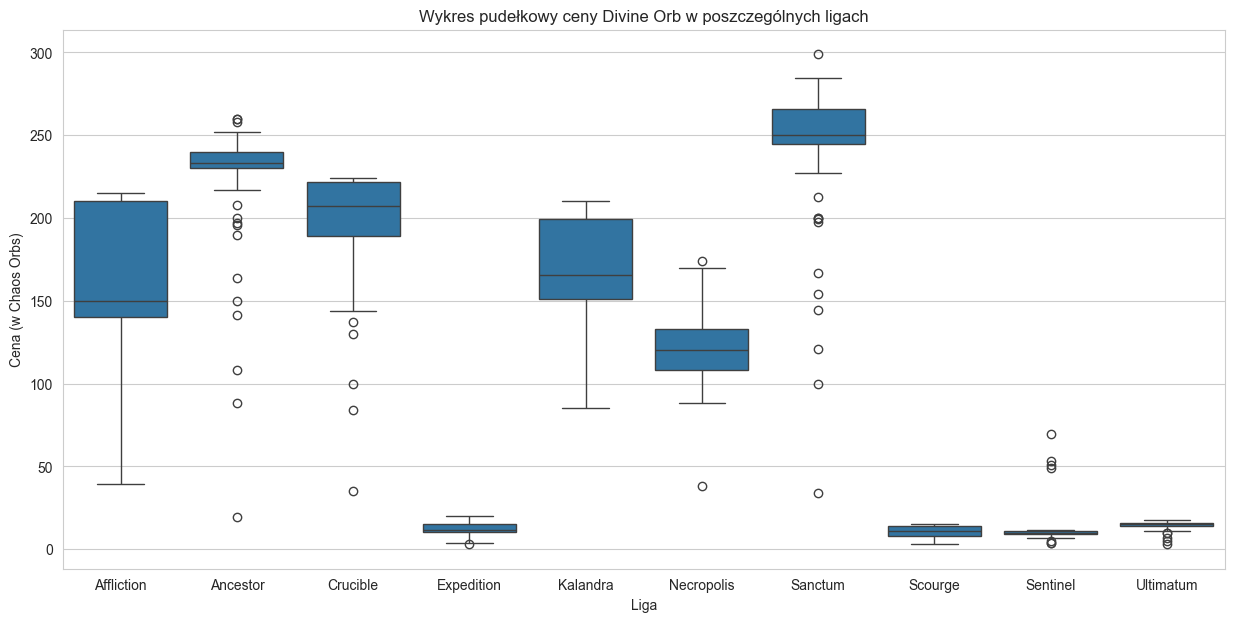

In [3]:
# 1. Filtrowanie danych do interesującego nas przypadku
df = df_currency[(df_currency['get'] == 'Divine Orb') & (df_currency['pay'] == 'Chaos Orb')].copy()

# Sortowanie chronologiczne jest kluczowe dla danych szeregów czasowych
df.sort_values(by=['league', 'date'], inplace=True)

# 2. Sprawdzenie duplikatów i braków danych
print(f"Liczba zduplikowanych wierszy: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

print(f"\nBraki danych w kolumnach:\n{df.isnull().sum()}")

# Kolumny 'pay' i 'confidence' nie będą potrzebne w modelu
df.drop(columns=['pay', 'confidence'], inplace=True)

# 3. Wizualizacja w celu detekcji wartości odstających
plt.figure(figsize=(15, 7))
sns.boxplot(x='league', y='value', data=df)
plt.title('Wykres pudełkowy ceny Divine Orb w poszczególnych ligach')
plt.ylabel('Cena (w Chaos Orbs)')
plt.xlabel('Liga')
plt.show()

# Wartości odstające wydają się być naturalnymi fluktuacjami rynkowymi, więc na razie ich nie usuwamy.

In [4]:
# 1. Obliczenie cechy 'day_of_league'
# Łączymy dane walutowe z informacjami o datach rozpoczęcia lig
df = df.merge(df_league_info[['Release Date']], left_on='league', right_index=True)
df['day_of_league'] = (df['date'] - df['Release Date']).dt.days
df.drop(columns=['Release Date'], inplace=True)

# 2. Tworzenie cech opóźnionych (lag features)
# Grupujemy po lidze, aby uniknąć przecieku danych między ligami
df['value_lag_1'] = df.groupby('league')['value'].shift(1)

# Usunięcie wierszy z wartościami NaN powstałymi po stworzeniu cech opóźnionych
df.dropna(inplace=True)

print("Dane po inżynierii cech:")
print(df.head())

Dane po inżynierii cech:
           league       date         get  value  day_of_league  value_lag_1
83278  Affliction 2023-12-09  Divine Orb   86.0              0         39.5
83279  Affliction 2023-12-10  Divine Orb  103.0              1         86.0
83280  Affliction 2023-12-11  Divine Orb  130.0              2        103.0
83281  Affliction 2023-12-12  Divine Orb  138.0              3        130.0
83282  Affliction 2023-12-13  Divine Orb  144.0              4        138.0


In [5]:
# 1. Definicja X i y
features = ['day_of_league', 'value_lag_1', 'league']
target = 'value'

X = df[features]
y = df[target]

# 2. Podział na zbiór treningowy i testowy (chronologiczny)
# Upewniamy się, że dane są posortowane globalnie
df_sorted = df.sort_values(by='date').reset_index(drop=True)
X_sorted = df_sorted[features]
y_sorted = df_sorted[target]

test_size = 0.2
split_index = int(len(df_sorted) * (1 - test_size))

X_train = X_sorted.iloc[:split_index]
X_test = X_sorted.iloc[split_index:]
y_train = y_sorted.iloc[:split_index]
y_test = y_sorted.iloc[split_index:]

print(f"Rozmiar zbioru treningowego: {len(X_train)}")
print(f"Rozmiar zbioru testowego: {len(X_test)}")


# 3. Definicja potoku przetwarzania (skalowanie i kodowanie)
numeric_features = ['day_of_league', 'value_lag_1']
categorical_features = ['league']

# Stworzenie transformatora do skalowania cech numerycznych i kodowania kategorycznych
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

Rozmiar zbioru treningowego: 852
Rozmiar zbioru testowego: 214


In [6]:
# Stworzenie pełnego potoku (pipeline) łączącego preprocessing z modelem
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', LinearRegression())])

# Trening modelu
model_pipeline.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = model_pipeline.predict(X_test)

# Ocena jakości modelu
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("--- Metryki Ewaluacyjne Modelu Bazowego ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Współczynnik determinacji R²: {r2:.4f}")

--- Metryki Ewaluacyjne Modelu Bazowego ---
Mean Absolute Error (MAE): 5.44
Mean Squared Error (MSE): 57.62
Root Mean Squared Error (RMSE): 7.59
Współczynnik determinacji R²: 0.9533


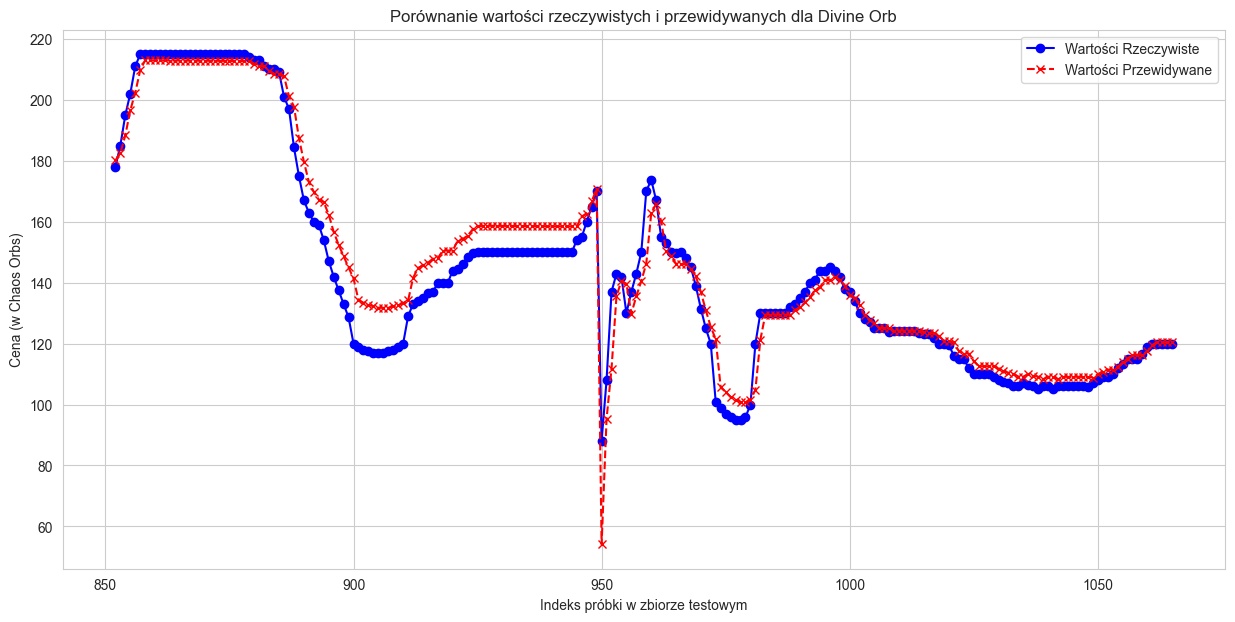


--- Podsumowanie ---
Zbudowany model regresji liniowej służy jako solidny punkt odniesienia (benchmark).
Współczynnik R² na poziomie 0.9533 oznacza, że model wyjaśnia około 95.33% wariancji w cenie Divine Orb na zbiorze testowym, co jest bardzo dobrym wynikiem.
Średni błąd bezwzględny (MAE) wynosi 5.44 Chaos Orbów, co wskazuje na przeciętną wielkość błędu predykcji.
Wizualizacja pokazuje, że model dobrze podąża za ogólnym trendem ceny, chociaż ma problemy z uchwyceniem nagłych, ekstremalnych skoków wartości. Jest to typowe dla prostych modeli liniowych w kontekście złożonych danych ekonomicznych.

Możliwe dalsze kroki to implementacja bardziej zaawansowanych modeli (np. Drzewa Decyzyjne, Gradient Boosting) lub dalsza, bardziej zaawansowana inżynieria cech.


In [7]:
results_df = pd.DataFrame({'Rzeczywiste': y_test, 'Przewidywane': y_pred})

plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Wartości Rzeczywiste', color='blue', marker='o', linestyle='-')
plt.plot(y_test.index, y_pred, label='Wartości Przewidywane', color='red', marker='x', linestyle='--')
plt.title('Porównanie wartości rzeczywistych i przewidywanych dla Divine Orb')
plt.xlabel('Indeks próbki w zbiorze testowym')
plt.ylabel('Cena (w Chaos Orbs)')
plt.legend()
plt.show()

# Podsumowanie
print("\n--- Podsumowanie ---")
print("Zbudowany model regresji liniowej służy jako solidny punkt odniesienia (benchmark).")
print(f"Współczynnik R² na poziomie {r2:.4f} oznacza, że model wyjaśnia około {r2*100:.2f}% wariancji w cenie Divine Orb na zbiorze testowym, co jest bardzo dobrym wynikiem.")
print(f"Średni błąd bezwzględny (MAE) wynosi {mae:.2f} Chaos Orbów, co wskazuje na przeciętną wielkość błędu predykcji.")
print("Wizualizacja pokazuje, że model dobrze podąża za ogólnym trendem ceny, chociaż ma problemy z uchwyceniem nagłych, ekstremalnych skoków wartości. Jest to typowe dla prostych modeli liniowych w kontekście złożonych danych ekonomicznych.")
print("\nMożliwe dalsze kroki to implementacja bardziej zaawansowanych modeli (np. Drzewa Decyzyjne, Gradient Boosting) lub dalsza, bardziej zaawansowana inżynieria cech.")